In [4]:
import itertools
import random
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import csr_matrix
from scipy.sparse import coo_matrix
from scipy.sparse.csgraph import dijkstra #フィボナッチヒープを使用している
import math
from tqdm import tqdm_notebook as tqdm
import pandas as pd
import time
import sys
sys.setrecursionlimit(20000)

%matplotlib inline

In [5]:
def make_random_graph_list(V_size, E_size):
    network_list = np.array([np.random.choice(range(V_size),2,replace=False) for i in range(E_size)])
    network_list = np.unique(network_list, axis=0)
    weighted = np.random.uniform(0,1,len(network_list))
    
    # from to と　weightedを連結
    return np.vstack([network_list.T, weighted]).T

In [6]:
# 確率を-log(p)変換する
def neg_log(network_np):
    return np.vstack([network_np.T[:2], -np.log(network_np.T[2])]).T

In [7]:
# plt.figure(figsize=(15,5))
# nx.draw_networkx(G)

In [8]:
def compute_MIP_G(G, theta):
    return dict(nx.all_pairs_dijkstra(G, cutoff=-np.log(theta)))

In [9]:
def compute_MIOA(v, G_table):
    MIOA = nx.DiGraph()
    for u_path in G_table[v][1].values():
        nx.add_path(MIOA, u_path)
    return MIOA

# theta = 0.00001
# G_table = compute_MIP_G(G, theta)

# MIOA = compute_MIOA(0, G_table)
# # nx.draw_networkx(MIOA)

In [10]:
def compute_MIIA(v, G_table, G):
    MIIA = nx.DiGraph()
    for node in G:
        if v in G_table[node][1]:
            nx.add_path(MIIA, G_table[node][1][v])
    return MIIA

def compute_MIIA_get(v, G_table, G):
    MIIA = nx.DiGraph()
    for node in G:
        if not node in MIIA:
            path = G_table[node][1].get(v)
            if path:
                nx.add_path(MIIA, path)
    return MIIA

def compute_MIIA_kai(v, G_path):
    MIIA = nx.DiGraph()
    for n, (dist, path) in tqdm(G_path):
        path_v = path.get(v)
        if path_v:
            nx.add_path(MIIA, path_v)
    return MIIA

# theta = 0.00001
# G_table = compute_MIP_G(G, theta)

# MIIA = compute_MIIA(2, G_table)
# # nx.draw_networkx(MIIA)

In [13]:
# G_path = nx.all_pairs_dijkstra(G)
# %timeit MIIA = compute_MIIA_kai(2, G_path)
# plt.figure(figsize=(15,10))
# nx.draw_networkx(MIIA)

In [15]:
def compute_ap(ap, S, MIIA_v, v, G_table):
    # MIIAtreeの末端から計算すれば、効率的になるため、ソート
    from_u_to_v_path_len = dict(nx.single_target_shortest_path_length(MIIA_v, v))
    sorted_path_len = sorted(from_u_to_v_path_len.items(), key=lambda x:x[1], reverse=True)
    
    for u, _ in sorted_path_len:
        if u in S:
            ap[(u, MIIA_v)] = 1
        else:
            N_in = MIIA_v.in_edges([u])
            if not N_in:
                ap[(u, MIIA_v)] = 0
            else:
                prod = 1
                for w, _ in N_in:
                    prod *= 1 - ap[(w, MIIA_v)] * np.exp(-G_table[w][0][u])
                ap[(u, MIIA_v)] = 1 - prod
                
# theta = 0.0001
# v = 2
# S = [3]
# G_table = compute_MIP_G(G, theta)
# MIIA_v = compute_MIIA(v, G_table)
# # nx.draw_networkx(MIIA_v)
# ap = dict()
# compute_ap(ap, S, MIIA_v, v, G_table)
# ap

In [16]:
def compute_alpha(alpha, v, MIIA_v, S, G_table, ap):
    # 木のルートからはじめると効率的に計算できる
    print(v, MIIA_v.node())
    from_u_to_v_path_len = dict(nx.single_target_shortest_path_length(MIIA_v, v))
    sorted_path_len = sorted(from_u_to_v_path_len.items(), key=lambda x:x[1])

    for u, _ in sorted_path_len:
        if u == v:
            alpha[(MIIA_v, u)] = 1
        else:
            w = list(MIIA_v.out_edges([u]))[0][1]
            if w in S:
                alpha[(MIIA_v, u)] = 0
            else:
                N_in = MIIA_v.in_edges([w])
                prod = 1
                for u_, _ in N_in:
                    if u_ != u:
                        prod *= 1 - ap[(u_, MIIA_v)] * np.exp(-G_table[u_][0][w])
                alpha[(MIIA_v, u)] = alpha[(MIIA_v, w)] * np.exp(-G_table[u][0][w]) * prod

# theta = 0.0001
# v = 2
# S = [3]
# G_table = compute_MIP_G(G, theta)
# MIIA_v = compute_MIIA(v, G_table)
# nx.draw_networkx(MIIA_v)
# ap = dict()
# compute_ap(ap, S, MIIA_v, v, G_table)

# alpha = dict()
# compute_alpha(alpha, v, MIIA_v, S, G_table, ap)
# alpha

In [17]:
def compute_MIA(G, k, theta):
    # initialization
    # 2
    S = []
    
    # 3
    IncInf = dict(zip(G.nodes(), [0]*len(G)))
    
    MIIA = dict()
    MIOA = dict()
    ap = dict()
    alpha = dict()
    
    # ダイクストラの計算を一括で行う
    G_table = compute_MIP_G(G, theta)
    
    
    # 4
    for v in tqdm(G):
        # 5
        MIIA[v] = compute_MIIA(v, G_table, G)
        MIOA[v] = compute_MIOA(v, G_table)
        
        # 6
        for u in MIIA[v]:
            ap[(u, MIIA[v])] = 0
        
        # 7
        compute_alpha(alpha, v, MIIA[v], S, G_table, ap)
        
        # 8
        for u in MIIA[v]:
            IncInf[u] += alpha[(MIIA[v], u)] * (1 - ap[(u, MIIA[v])])
    print("complete initilization")
    
    # main loop
    # 13
    for i in range(k):
        # 14
        u = sorted(IncInf.items(), key=lambda x:x[1], reverse=True)[0][0]
        print("u",u)
        
        # 16
        for v in MIOA[u]:
            if not v in S:
                for w in MIIA[v]:
                    if not w in S:
                        IncInf[w] -= alpha[(MIIA[v], w)] * (1 - ap[(w, MIIA[v])])
        # 22
        S += [u]
        
        if len(S) == k:
            return S
        
        # 23
        for v in MIOA[u]:
            if not v in S:
                # 24
                compute_ap(ap, S, MIIA[v], v, G_table)
                
                # 25
                compute_alpha(alpha, v, MIIA[v], S, G_table, ap)
                
                # 27
                for w in MIIA[v]:
                    if not w in S:
                        # 28
                        IncInf[w] += alpha[(MIIA[v], w)] * (1 - ap[(w, MIIA[v])])

# csrで行う場合

In [18]:
network_np = make_random_graph_list(8, 10)

In [19]:
def compute_MIIOA(g, theta):
    from_node = [int(i) for i in g.T[0]]
    to_node = [int(i) for i in g.T[1]]
    N = max(max(from_node), max(to_node)) + 1
    prob_data = -np.log(g.T[2])
    coo = coo_matrix((prob_data, (from_node, to_node)), (N, N)).tocsr()
    return dijkstra(coo, return_predecessors=True, limit=-np.log(theta))

# from_node = [int(i) for i in network_np.T[0]]
# to_node = [int(i) for i in network_np.T[1]]
# N = max(max(from_node),max(to_node))+1
# prob_data = -np.log(network_np.T[2])
# coo = coo_matrix((prob_data, (from_node, to_node)), (N, N)).tocsr()
# theta = 0.00001
# result = dijkstra(coo, return_predecessors=True, limit=-np.log(theta))

In [20]:
def get_pass(start, end, pass_info):
    shortest_pass = []
    t = int(end)
    while t != -9999:
        shortest_pass.append(t)
        t = pass_info[t]
        if t == start:
            shortest_pass.append(start)
            shortest_pass.reverse()
            return shortest_pass
    return []

In [21]:
def compute_MIIA_csr(v, G, G_table):
    MIIA = nx.DiGraph()
    for u in G:
        path = get_pass(u, v, G_table[1][int(u)])
        nx.add_path(MIIA, path)
    return MIIA
# nx.draw_networkx(compute_MIIA_csr(0, result))

In [22]:
def compute_MIOA_csr(v, G, G_table):
    MIOA = nx.DiGraph()
    for u in G:
        path = get_pass(v, u, G_table[1][int(u)])
        nx.add_path(MIOA, path)
    return MIOA
# nx.draw_networkx(compute_MIIA_csr(0, result))

In [23]:
def pp_csr(u, v, G_table):
    return np.exp(1)**(-G_table[0][int(u)][int(v)])

In [24]:
def compute_ap_csr(ap, S, MIIA_v, v, G_table):
    # MIIAtreeの末端から計算すれば、効率的になるため、ソート
    from_u_to_v_path_len = dict(nx.single_target_shortest_path_length(MIIA_v, v))
    sorted_path_len = sorted(from_u_to_v_path_len.items(), key=lambda x:x[1], reverse=True)
    
    for u, _ in sorted_path_len:
        if u in S:
            ap[(u, MIIA_v)] = 1
        else:
            N_in = MIIA_v.in_edges([u])
            if not N_in:
                ap[(u, MIIA_v)] = 0
            else:
                prod = 1
                for w, _ in N_in:
                    prod *= 1 - ap[(w, MIIA_v)] * np.exp(-pp_csr(w, u, G_table))
                ap[(u, MIIA_v)] = 1 - prod

In [25]:
def compute_alpha_csr(alpha, v, MIIA_v, S, G_table, ap):
    # 木のルートからはじめると効率的に計算できる
    print(v, MIIA_v.node())
    from_u_to_v_path_len = dict(nx.single_target_shortest_path_length(MIIA_v, v))
    sorted_path_len = sorted(from_u_to_v_path_len.items(), key=lambda x:x[1])

    for u, _ in sorted_path_len:
        if u == v:
            alpha[(MIIA_v, u)] = 1
        else:
            w = list(MIIA_v.out_edges([u]))[0][1]
            if w in S:
                alpha[(MIIA_v, u)] = 0
            else:
                N_in = MIIA_v.in_edges([w])
                prod = 1
                for u_, _ in N_in:
                    if u_ != u:
                        prod *= 1 - ap[(u_, MIIA_v)] * np.exp(-pp_csr(u_, w, G_table))
                alpha[(MIIA_v, u)] = alpha[(MIIA_v, w)] * np.exp(-pp_csr(u, w, G_table)) * prod

In [26]:
def compute_MIA_csr(g, k, theta):
    MIIA = dict()
    MIOA = dict()
    ap = dict()
    alpha = dict()
    
    # グラフの準備
    g_log = neg_log(g)
    G_table = compute_MIIOA(g_log, theta)
    
    # グラフ作成
    G = nx.DiGraph()
    G.add_weighted_edges_from(g_log)
    
    # initialization
    # 2
    S = []
    
    # 3
    IncInf = dict(zip(G.nodes(), [0]*len(G)))
    
    MIIA_time = []
    MIOA_time = []
    ap_time = []
    alpha_time = []
    IncInf_time = []
    
    # 4
    for v in tqdm(G):
        # 5
        start = time.time()
        MIIA[v] = compute_MIIA_csr(v, G, G_table)
        MIIA_time.append(time.time()-start)
        
        start = time.time()
        MIOA[v] = compute_MIOA_csr(v, G, G_table)
        MIOA_time.append(time.time()-start)
        
        # 6
        start = time.time()
        for u in MIIA[v]:
            ap[(u, MIIA[v])] = 0
        ap_time.append(time.time()-start)
        
        # 7
        start = time.time()
        compute_alpha_csr(alpha, v, MIIA[v], S, G_table, ap)
        alpha_time.append(time.time()-start)
        
        # 8
        start = time.time()
        for u in MIIA[v]:
            IncInf[u] += alpha[(MIIA[v], u)] * (1 - ap[(u, MIIA[v])])
        IncInf_time.append(time.time()-start)
    return [MIIA_time, MIOA_time, ap_time, alpha_time, IncInf_time]
    print("complete initilization")
    
    # main loop
    # 13
    for i in range(k):
        # 14
        u = sorted(IncInf.items(), key=lambda x:x[1], reverse=True)[0][0]
        print("u",u)
        
        # 16
        for v in MIOA[u]:
            if not v in S:
                for w in MIIA[v]:
                    if not w in S:
                        IncInf[w] -= alpha[(MIIA[v], w)] * (1 - ap[(w, MIIA[v])])
        # 22
        S += [u]
        
        if len(S) == k:
            return S
        
        # 23
        for v in MIOA[u]:
            if not v in S:
                # 24
                compute_ap_csr(ap, S, MIIA[v], v, G_table)
                
                # 25
                compute_alpha_csr(alpha, v, MIIA[v], S, G_table, ap)
                
                # 27
                for w in MIIA[v]:
                    if not w in S:
                        # 28
                        IncInf[w] += alpha[(MIIA[v], w)] * (1 - ap[(w, MIIA[v])])

In [722]:
%time time = compute_MIA_csr(network_np, 3, 0.5)

/Users/fuekimasao/anaconda3/envs/use/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Graph has negative weights: dijkstra will give inaccurate results if the graph contains negative cycles. Consider johnson or bellman_ford.
  import sys


0.0 [0.0, 7.0, 2.0, 6.0, 3.0, 4.0, 1.0, 5.0]


KeyError: (<networkx.classes.digraph.DiGraph object at 0xa6f190dd0>, 7.0)

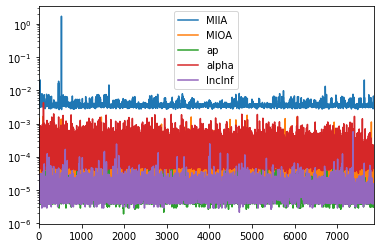

In [426]:
time_df = pd.DataFrame({"MIIA":time[0], "MIOA":time[1], "ap":time[2], "alpha":time[3], "IncInf":time[4]})
time_df.plot(logy=True)

## MIA time

In [288]:
theta = 0.1
%time G_table = compute_MIP_G(G, theta)

CPU times: user 640 ms, sys: 21.6 ms, total: 662 ms
Wall time: 660 ms


In [302]:
%%time
MIIA = dict()

for v in tqdm(G):
    MIIA[v] = compute_MIIA(v, G_table, G)


CPU times: user 1min 29s, sys: 2.93 s, total: 1min 32s
Wall time: 1min 37s


In [303]:
%%time 
MIOA = dict()
for v in tqdm(G):
    MIOA[v] = compute_MIOA(v, G_table)


CPU times: user 31.6 s, sys: 1.55 s, total: 33.2 s
Wall time: 34.4 s


# データを読み込んで行う場合

In [396]:
# データの読み込み
# 枝確率を計算済みのネットワークを読み込む
network = pd.read_csv("data.csv")
network.head()

,# FromNodeId,ToNodeId,p
0,0,4,0.008000
1,0,5,0.005682
2,0,7,0.033333
3,0,8,0.009615
4,0,9,0.066667


In [397]:
# numpy型に変換
network_np = network.values

In [398]:
network_np_log = neg_log(network_np)

In [399]:
# 空の有向グラフを作成
G = nx.DiGraph()

In [400]:
# 重み付きの枝を加える
G.add_weighted_edges_from(network_np_log)

In [714]:
%time compute_MIA(G, 3, 0.5)

0.0 [0.0, 6.0]
7.0 [0.0, 7.0, 6.0]
2.0 [2.0, 4.0]
6.0 [6.0]
3.0 [3.0]
4.0 [4.0]
1.0 [4.0, 1.0]
5.0 [5.0]

complete initilization
u 6.0
0.0 [0.0, 6.0]
7.0 [0.0, 7.0, 6.0]
u 4.0
1.0 [4.0, 1.0]
2.0 [2.0, 4.0]
u 3.0
CPU times: user 54.7 ms, sys: 7.9 ms, total: 62.6 ms
Wall time: 69.4 ms


[6.0, 4.0, 3.0]

/Users/fuekimasao/anaconda3/envs/use/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/fuekimasao/anaconda3/envs/use/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


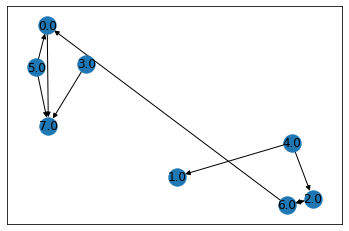

In [710]:
nx.draw_networkx(G)

In [27]:
# 速度比較
G = nx.DiGraph()
network = pd.read_csv("data.csv")
network_np = network.values

g_log = neg_log(network_np)
# 重み付きの枝を加える
G.add_weighted_edges_from(g_log)

theta = 0.01
v = 5

In [742]:
G_table1 = compute_MIP_G(G, theta)

In [743]:
res1 = compute_MIIA(v, G_table1, G)

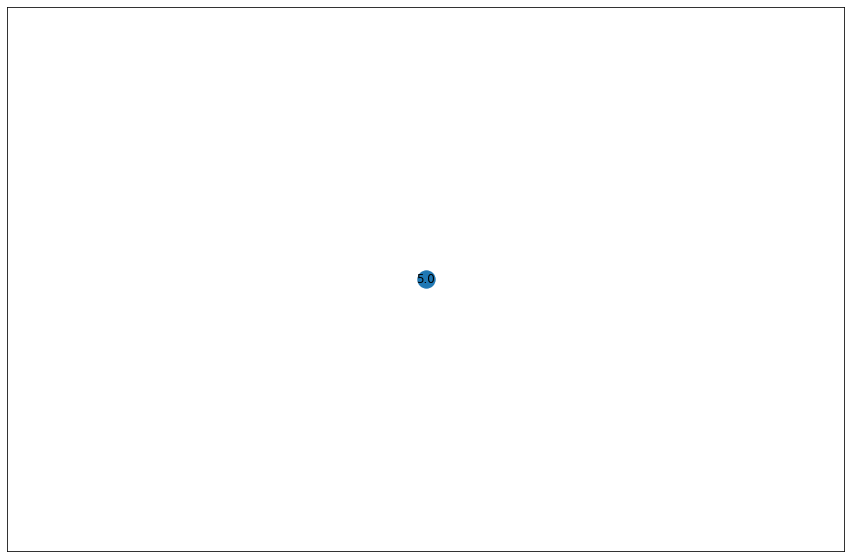

In [745]:
plt.figure(figsize=(15,10))
nx.draw_networkx(res1)

In [ ]:
G_table2 = compute_MIIOA(g_log, theta)

/Users/fuekimasao/anaconda3/envs/use/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
/Users/fuekimasao/anaconda3/envs/use/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Graph has negative weights: dijkstra will give inaccurate results if the graph contains negative cycles. Consider johnson or bellman_ford.
  import sys


In [ ]:
res2 = compute_MIIA_csr(v, G, G_table2)

In [ ]:
plt.figure(figsize=(15,10))
nx.draw_networkx(res2)

In [28]:
g_log

array([[ 0.00000000e+00,  4.00000000e+00,  4.82831374e+00],
       [ 0.00000000e+00,  5.00000000e+00,  5.17048400e+00],
       [ 0.00000000e+00,  7.00000000e+00,  3.40119738e+00],
       ...,
       [ 7.58850000e+04,  1.60860000e+04,  1.38629436e+00],
       [ 7.58860000e+04,  5.14140000e+04,  1.60943791e+00],
       [ 7.58870000e+04,  5.20980000e+04, -0.00000000e+00]])

In [ ]:
theta = 0.01

from_node = [int(i) for i in g_log.T[0]]
to_node = [int(i) for i in g_log.T[1]]
print("*")
N = max(max(from_node), max(to_node)) + 1
prob_data = -np.log(g_log.T[2])
coo = coo_matrix((prob_data, (from_node, to_node)), (N, N)).tocsr()
dijkstra(coo, return_predecessors=True, limit=-np.log(theta))

*


/Users/fuekimasao/anaconda3/envs/use/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
/Users/fuekimasao/anaconda3/envs/use/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Graph has negative weights: dijkstra will give inaccurate results if the graph contains negative cycles. Consider johnson or bellman_ford.
  if __name__ == '__main__':
